### More Feature Evaluation

More notes on this can be found in comments within features.py

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('../BIA660D_Group_1_Project/eda/hoboken_step2.csv')
data.head(3)

,user_rating,user_text,restaurant_name,restaurant_rating,restaurant_price,restaurant_type,review_len,mispelling_count
0,5,We booked Grand Vin as our brunch location to ...,Grand Vin,3.994975,2.0,"['Wine Bars', 'Italian', 'Cocktail Bars']",744,0
1,4,Sooooo for date night it was his turn to pick ...,Grand Vin,4.000000,2.0,"['Wine Bars', 'Italian', 'Cocktail Bars']",1344,0
2,5,Adorable little wine bar with outdoor seating ...,Grand Vin,3.994975,2.0,"['Wine Bars', 'Italian', 'Cocktail Bars']",723,0


OK now lets try to see if there are visible relationships between features and the dependent variable. 

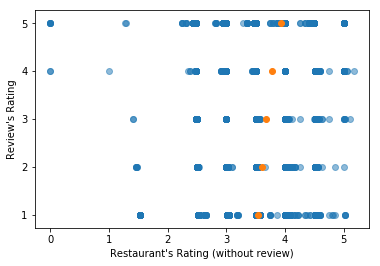

In [10]:
import matplotlib.pyplot as plt 
avg = {}
for i in range(1,6): 
    temp = data['restaurant_rating'][np.where(data['user_rating'] == i)[0]]
    avg[i] = np.mean(temp)
plt.scatter(data['restaurant_rating'], data['user_rating'], alpha = 0.5)
plt.scatter(avg.values(), avg.keys())
plt.xlabel("Restaurant's Rating (without review)")
plt.ylabel("Review's Rating")
plt.show()

As we can see, there is a visible relationship between the existing restaurant rating (the rating it would have if it were calculated excluding the review in question) and the review's rating. The trend is clear and linear but is much more dispersed than one might assume. We can also see that restaurants with a pre-existing rating of 0 (i.e. those restaurants who were not yet rated) tended to be rated favorably in their first reviews. 

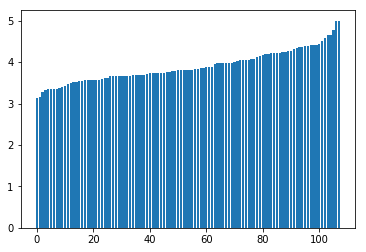

In [22]:
type_to_ratings = pd.read_csv('../BIA660D_Group_1_Project/eda/type_data.csv')
type_to_ratings.sort_values(by='Average_Score', inplace=True)
plt.figure()
plt.bar(range(108), type_to_ratings['Average_Score'])
# plt.xticks(range(108), type_to_ratings.iloc[:,0]) #No need for this, unreadable anyway
plt.show()

Despite not being able to identify any specific restaurant categories, we can see that the category does indeed have an effect on the review that the restaurants get. Since using one-hot-encoding for all these would lead to tons of dummy variables that could have an effect of overfitting, perhaps we can use bagging? We shall see. 

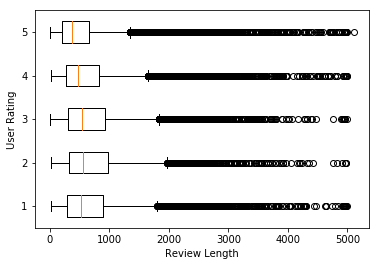

In [29]:
length_to_ratings = data[['review_len', 'user_rating']]
plt.figure()
# plt.scatter(data['review_len'], data['user_rating'])
w_one = list(length_to_ratings['review_len'][np.where(length_to_ratings['user_rating']==1)[0]])
w_two = list(length_to_ratings['review_len'][np.where(length_to_ratings['user_rating']==2)[0]])
w_three = list(length_to_ratings['review_len'][np.where(length_to_ratings['user_rating']==3)[0]])
w_four = list(length_to_ratings['review_len'][np.where(length_to_ratings['user_rating']==4)[0]])
w_five = list(length_to_ratings['review_len'][np.where(length_to_ratings['user_rating']==5)[0]])
all_five = [w_one, w_two, w_three, w_four, w_five]
plt.boxplot(all_five, vert=False)
plt.xlabel("Review Length")
plt.ylabel("User Rating")
plt.show()

Unfortunately the trend here isn't as visible, however, the average review length for "average reviews" (2's and 3's) are all longer than the average review length for the rest. Also, the average (and quartiles) for 5-star reviews are lower than any of the others. These are relationships that some non-linear models may be able to pick up. Bagging may be less useful in this instance.

<Figure size 432x288 with 0 Axes>

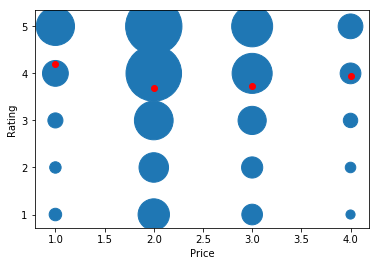

In [40]:
price_to_ratings = data[['restaurant_price', 'user_rating']].apply(round) 
#^ map the unknown values (previously recorded as the mean) onto the median
# price_to_ratings['dummy'] = price_to_ratings['restaurant_price'].apply(str) + price_to_ratings['user_rating'].apply(str)
temp = pd.DataFrame(columns=['Price', 'Rating', 'Count'], index=range(20)).fillna(0)
temp['Price'] = [1] * 5 + [2] * 5 + [3] * 5 + [4] * 5
temp['Rating'] = list(np.sort(price_to_ratings['user_rating'].unique()))*4
for row_n in range(len(temp)): 
    the_price = temp.iloc[row_n]['Price']
    the_rating = temp.iloc[row_n]['Rating']
    selection = price_to_ratings.iloc[np.where(price_to_ratings['restaurant_price'] == the_price)[0]]
    the_count = len(selection.iloc[np.where(selection['user_rating'] == the_rating)[0]])
    temp.iloc[row_n]['Count'] = the_count
#price_to_ratings.groupby(['restaurant_price', 'user_rating']).count()
avg = {}
for i in range(1,5): 
    selection = price_to_ratings['user_rating'][np.where(price_to_ratings['restaurant_price'] == i)[0]]
    avg[i] = np.mean(selection)
plt.figure()
temp.plot.scatter(x='Price', y='Rating', s=temp['Count']*0.25)
plt.scatter(avg.keys(), avg.values(), c='r')
plt.show()

As we can see from this bubble chart, while the most common category by far is the level-2 price group, it has lower ratings on average than the rest of price groups. Since level-1 and level-3 have higher average ratings than level-2, this trend is not linear, and will be captured by a nonlinear model. 

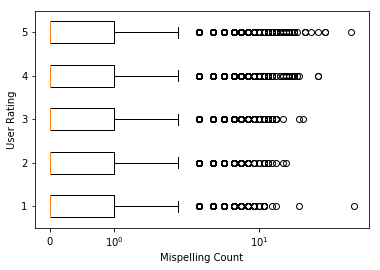

In [68]:
mispelling_to_ratings = data[['mispelling_count', 'user_rating']]
# plt.scatter(mispelling_to_ratings['mispelling_count'], mispelling_to_ratings['user_rating'])
#
# plt.scatter(data['review_len'], data['user_rating'])
w_one = list(mispelling_to_ratings['mispelling_count'][np.where(mispelling_to_ratings['user_rating']==1)[0]])
w_two = list(mispelling_to_ratings['mispelling_count'][np.where(mispelling_to_ratings['user_rating']==2)[0]])
w_three = list(mispelling_to_ratings['mispelling_count'][np.where(mispelling_to_ratings['user_rating']==3)[0]])
w_four = list(mispelling_to_ratings['mispelling_count'][np.where(mispelling_to_ratings['user_rating']==4)[0]])
w_five = list(mispelling_to_ratings['mispelling_count'][np.where(mispelling_to_ratings['user_rating']==5)[0]])
all_five = [w_one, w_two, w_three, w_four, w_five]
ax = plt.subplot()
plt.boxplot(all_five, vert=False)
plt.xlabel("Mispelling Count")
plt.ylabel("User Rating")
#
ax.set_xscale('symlog', nonposx='clip')
plt.show()

Ok so that box plot wasn't so informative. Very few of the reviews had many mispellings in them, ultimately, the second and third quartiles ended up the same for all user rating categories. If we examine the outliers though, one can see that there may be some pattern there in actuality. Lets look into this more. 

<Figure size 432x288 with 0 Axes>

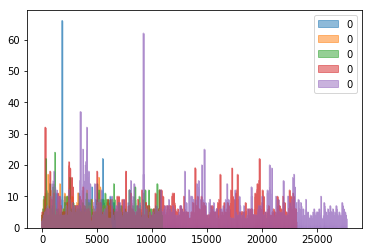

In [86]:
plt.figure()
fig, axes = plt.subplots()
# new_df = pd.DataFrame(data=)
# a = pd.DataFrame(w_one)
pd.DataFrame(w_one).plot.area(stacked=False, ax=axes)
pd.DataFrame(w_two).plot.area(stacked=False, ax=axes)
pd.DataFrame(w_three).plot.area(stacked=False, ax=axes)
pd.DataFrame(w_four).plot.area(stacked=False, ax=axes)
pd.DataFrame(w_five).plot.area(stacked=False, ax=axes)
# plt.set_yscale('log', nonposx='clip') #not working
plt.show()

Ok so sadly that wasn't too informative either. Nontheless, even without a clearly visible linear trend, nonlinearities may be present. 